# 3D Alexandria Advanced

![alexandria_3d](images/alexandria_3d_database.png)


In this example, we will be using ParquetDB to do some analysis on the 3D Alexandria database. This assumes you have already done Example 1 - 3D Alexandria Database. In that example, we created a database from scratch. Here, we will be using the pre-existing database.

Materials can be classified into four main electronic categories based on their **band gap** characteristics: **semiconductors**, **insulators**, **metals**, and **semimetals**. The band gap is a crucial property that determines how a material conducts electricity and interacts with electromagnetic waves. This section of the notebook explores how to identify these categories by analyzing the **direct band gap** (`band_gap_dir`) and **indirect band gap** (`band_gap_ind`) values stored in the database.

#### Key Concepts:
1. **Band Gap**: The energy difference between the material's valence band (occupied by electrons) and conduction band (unoccupied). It determines whether a material can conduct electricity:
   - A **large band gap** indicates that the material does not conduct electricity easily, making it an **insulator**.
   - A **small band gap** allows for moderate conductivity, characterizing **semiconductors**.
   - A **zero band gap** suggests that electrons can move freely, which is typical of **metals** or **semimetals**.

2. **Direct Band Gap vs. Indirect Band Gap**:
   - **Direct Band Gap**: Electrons can transition directly between the valence and conduction bands without a change in momentum. This is particularly important for optoelectronic applications (e.g., LEDs and lasers).
   - **Indirect Band Gap**: Electron transitions require a change in momentum, involving interactions with the material's lattice vibrations (phonons).

#### Material Categories:
- **Semiconductors**:
  - Band gap (direct or indirect): **0.1 to 3 eV**.
  - These materials exhibit moderate electrical conductivity, making them crucial for electronic devices like transistors and solar cells.
  
- **Insulators**:
  - Band gap (direct): **> 3 eV**.
  - These materials do not conduct electricity under normal conditions due to their large band gap.

- **Metals**:
  - Direct band gap: **0 eV**.
  - Metals lack a band gap, allowing free movement of electrons, making them excellent conductors of electricity and heat.

- **Semimetals**:
  - Band gap (direct or indirect): **< 0.1 eV**.
  - Semimetals have small or negligible band gaps, resulting in electronic behavior that lies between metals and semiconductors.

---

#### What You'll Learn in This Section
In the following cells, we:
1. Query the database to identify materials in each category.
2. Measure the time it takes to filter the data for performance benchmarking.
3. Extract the number of materials belonging to each category.

### Setup

In [ ]:
!pip install parquetdb

In [10]:
import os
import time
import copy

import pandas as pd
from pyarrow import compute as pc
import pyarrow as pa
import matplotlib.pyplot as plt

from parquetdb import ParquetDB, config
from parquetdb.utils.external_utils import plot_periodic_table_heatmap

%matplotlib inline

In [11]:
db_path = os.path.join(
    config.data_dir, "external", "alexandria", "AlexandriaDB", "alexandria_3D"
)
db = ParquetDB(db_path=db_path)
print(db)

PARQUETDB SUMMARY
Database path: Z:\data\parquetdb\data\external\alexandria\AlexandriaDB\alexandria_3D

• Number of columns: 128
• Number of rows: 4389295
• Number of files: 1
• Number of rows per file: [4389295]
• Number of row groups per file: [22]
• Serialized metadata size per file: [377883] Bytes

############################################################
METADATA
############################################################

############################################################
COLUMN DETAILS
############################################################



## Filtering for Electronic Categories

In this section, we will filter the database to identify materials in each electronic category. We can easily do this with ParquetDB's `read` method and applying the appropriate filters.

In [3]:
def create_semiconductor_filter():

    # Define direct and indirect band gap filters between 0.1 and 3 eV
    band_gap_dir_in_range = (pc.field("data.band_gap_dir") >= 0.1) & (
        pc.field("data.band_gap_dir") <= 3
    )
    band_gap_ind_in_range = (pc.field("data.band_gap_ind") >= 0.1) & (
        pc.field("data.band_gap_ind") <= 3
    )

    # Define conditional expression to handle the interaction between direct and indirect band gaps
    filtered_expr = pc.if_else(
        (pc.field("data.band_gap_ind") != 0)
        & (pc.field("data.band_gap_ind") < pc.field("data.band_gap_dir")),
        band_gap_ind_in_range,
        band_gap_dir_in_range,
    )
    return filtered_expr


def create_insulator_filter():
    return pc.field("data.band_gap_dir") > 3


def create_metal_filter():
    return pc.field("data.band_gap_dir") == 0


def create_semimetal_filter():

    # Define direct and indirect band gap filters for semimetals. Less than 0.1 eV
    band_gap_dir_in_range = pc.field("data.band_gap_dir") < 0.1
    band_gap_ind_in_range = pc.field("data.band_gap_ind") < 0.1

    # Define conditional expression to handle the interaction between direct and indirect band gaps
    filtered_expr = pc.if_else(
        (pc.field("data.band_gap_ind") != 0)
        & (pc.field("data.band_gap_ind") < pc.field("data.band_gap_dir")),
        band_gap_ind_in_range,
        band_gap_dir_in_range,
    )
    return filtered_expr


semiconductor_filter = create_semiconductor_filter()
insulator_filter = create_insulator_filter()
metal_filter = create_metal_filter()
semimetal_filter = create_semimetal_filter()

Now, let's apply these filters to determine the distribution of materials in each category.

Here, I do not want the entire table, just the ids. If you read all the columns, you will likely run out of memory.

I will also get the band gap values to verify the results.


In [4]:
start_time = time.time()
semiconductor_table = db.read(
    columns=["id", "data.band_gap_dir", "data.band_gap_ind"],
    filters=[semiconductor_filter],
)
insulator_table = db.read(
    columns=["id", "data.band_gap_dir", "data.band_gap_ind"], filters=[insulator_filter]
)
metal_table = db.read(
    columns=["id", "data.band_gap_dir", "data.band_gap_ind"], filters=[metal_filter]
)
semimetal_table = db.read(
    columns=["id", "data.band_gap_dir", "data.band_gap_ind"], filters=[semimetal_filter]
)
time_to_find_electronic_categories = time.time() - start_time

n_semiconductors = semiconductor_table.shape[0]
n_insulators = insulator_table.shape[0]
n_metals = metal_table.shape[0]
n_semimetals = semimetal_table.shape[0]

print(f"Number of semiconductors: {n_semiconductors}")
print(f"Number of insulators: {n_insulators}")
print(f"Number of metals: {n_metals}")
print(f"Number of semimetals: {n_semimetals}")

print(
    f"Time to find electronic categories: {time_to_find_electronic_categories:.4f} seconds"
)

Number of semiconductors: 428588
Number of insulators: 59913
Number of metals: 2255051
Number of semimetals: 3905069
Time to find electronic categories: 0.9017 seconds


Great, we have the number of materials in each category and it took about ~0.27 seconds. 

Again, to highlight the usefulness of ParquetDB, if we were to do this with the data in json format, it would take ~600 seconds for each individual query unless we extracted the different categories at the same time. Still take at minimum ~600 seconds to do this.

Now, let's plot the distribution of band gaps for each category.

Semiconductors: Direct Band Gap (Minimum, Maximum): (0.1, 5.3968), Indirect Band Gap (Minimum, Maximum): (0.0, 3.0)
Small Gap Materials: Direct Band Gap (Minimum, Maximum): (0.0, 3.1953), Indirect Band Gap (Minimum, Maximum): (0.0, 0.0999)
Metals: Direct Band Gap (Minimum, Maximum): (0.0, 0.0), Indirect Band Gap (Minimum, Maximum): (0.0, 0.0)
Insulators: Direct Band Gap (Minimum, Maximum): (3.0001, 18.3179), Indirect Band Gap (Minimum, Maximum): (0.0, 17.7628)


C:\Users\lllang\AppData\Local\Temp\ipykernel_72436\2214734742.py:62: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_gap_dir, max_gap_dir)


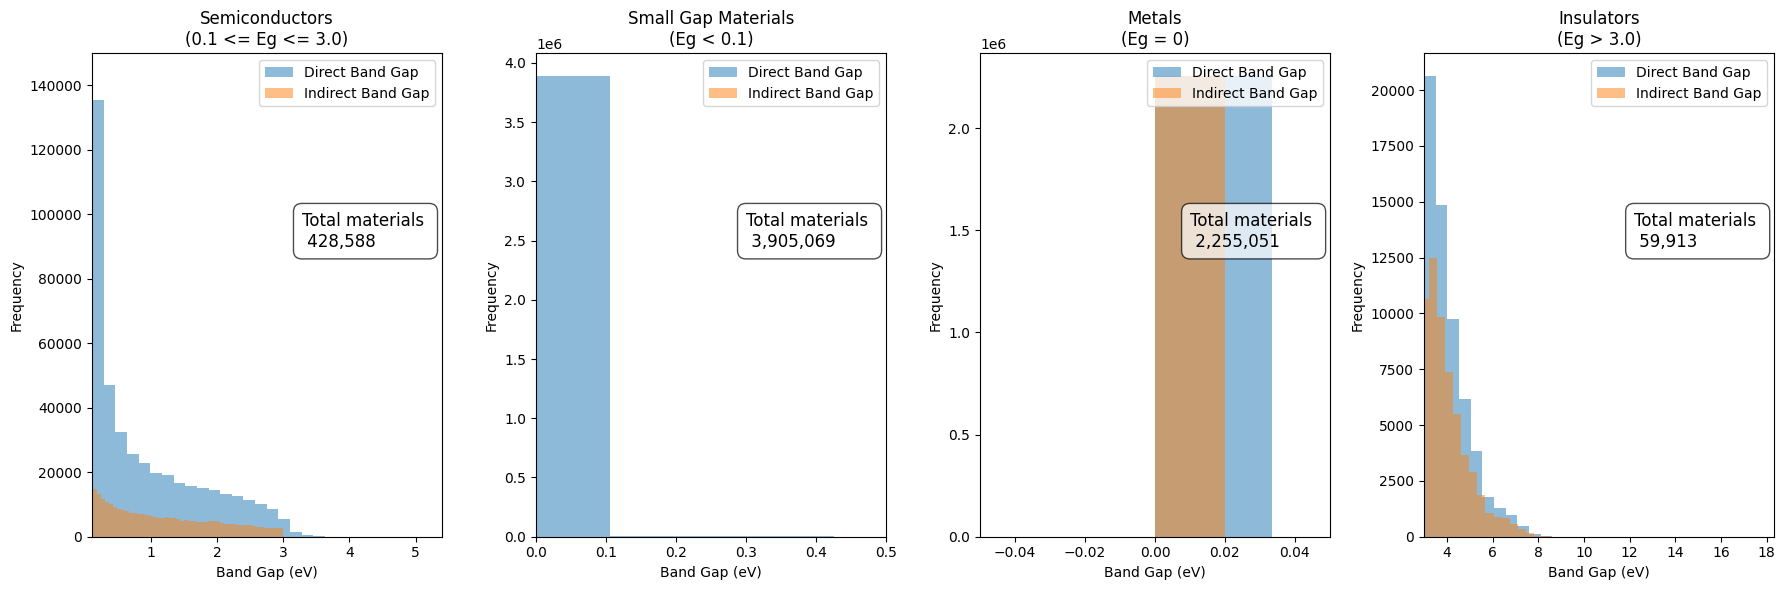

In [24]:
def plot_band_gap_distribution(
    semiconductor_table, semimetal_table, metal_table, insulator_table
):
    # Band gap ranges and materials info
    band_gap_ranges = ["0.1 <= Eg <= 3.0", "Eg < 0.1", "Eg = 0", "Eg > 3.0"]
    materials = ["Semiconductors", "Small Gap Materials", "Metals", "Insulators"]

    # Convert PyArrow tables to Pandas DataFrames
    df_semiconductors = semiconductor_table.to_pandas()
    df_semimetals = semimetal_table.to_pandas()
    df_metals = metal_table.to_pandas()
    df_insulators = insulator_table.to_pandas()

    # Create a 2x2 grid of subplots
    # fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    axs = axs.flatten()  # Flatten the 2D array for easy iteration

    # Define a helper function for plotting the distributions
    def plot_band_gap_distribution(ax, df, material, band_gap_range):
        # Plot histogram for direct band gap
        ax.hist(
            df["data.band_gap_dir"],
            bins=30,
            alpha=0.5,
            label="Direct Band Gap",
            color="tab:blue",
        )
        # Plot histogram for indirect band gap
        ax.hist(
            df["data.band_gap_ind"],
            bins=50,
            alpha=0.5,
            label="Indirect Band Gap",
            color="tab:orange",
        )
        
        # Add text to indicate the total number of materials
        total_count = len(df)
        ax.text(
            0.6, 0.6, 
            f"Total materials \n {total_count:,}",
            transform=ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5')
        )

        # Set x limits based on min and max of both distributions
        # min_gap = min(df["data.band_gap_dir"].min(), df["data.band_gap_ind"].min())
        # max_gap = max(df["data.band_gap_dir"].max(), df["data.band_gap_ind"].max())

        min_gap_dir = df["data.band_gap_dir"].min()
        max_gap_dir = df["data.band_gap_dir"].max()
        min_gap_ind = df["data.band_gap_ind"].min()
        max_gap_ind = df["data.band_gap_ind"].max()
        print(
            f"{material}: Direct Band Gap (Minimum, Maximum): ({min_gap_dir}, {max_gap_dir}), Indirect Band Gap (Minimum, Maximum): ({min_gap_ind}, {max_gap_ind})"
        )
        if material == "Small Gap Materials":
            ax.set_xlim(min_gap_dir, 0.5)
        else:
            ax.set_xlim(min_gap_dir, max_gap_dir)

        ax.set_title(f"{material}\n({band_gap_range})", fontsize=12)
        ax.set_xlabel("Band Gap (eV)")
        ax.set_ylabel("Frequency")
        ax.legend()

    # Plot each material category in its corresponding subplot
    plot_band_gap_distribution(
        axs[0], df_semiconductors, materials[0], band_gap_ranges[0]
    )
    plot_band_gap_distribution(axs[1], df_semimetals, materials[1], band_gap_ranges[1])
    plot_band_gap_distribution(axs[2], df_metals, materials[2], band_gap_ranges[2])
    plot_band_gap_distribution(axs[3], df_insulators, materials[3], band_gap_ranges[3])

    plt.tight_layout()
    plt.show()


plot_band_gap_distribution(
    semiconductor_table, semimetal_table, metal_table, insulator_table
)


Great this is a good visualization of the band gap distribution for each category. This is a good way to check if our filters are working as expected.

## Element Distribution of Electronic Categories

Another interesting thing to look at is the distribution of elements in each category. We can do this by counting the number of times an element appears in each category.

For this task we need to create a dictionary which will keep track of the number of times an element appears in each category.

Let's look at the schema to figure out what columns would be best to use for this task.

In [25]:
schema = db.get_schema()
print(schema)

@class: string
@module: string
composition.Ac: double
composition.Ag: double
composition.Al: double
composition.Ar: double
composition.As: double
composition.Au: double
composition.B: double
composition.Ba: double
composition.Be: double
composition.Bi: double
composition.Br: double
composition.C: double
composition.Ca: double
composition.Cd: double
composition.Ce: double
composition.Cl: double
composition.Co: double
composition.Cr: double
composition.Cs: double
composition.Cu: double
composition.Dy: double
composition.Er: double
composition.Eu: double
composition.F: double
composition.Fe: double
composition.Ga: double
composition.Gd: double
composition.Ge: double
composition.H: double
composition.He: double
composition.Hf: double
composition.Hg: double
composition.Ho: double
composition.I: double
composition.In: double
composition.Ir: double
composition.K: double
composition.Kr: double
composition.La: double
composition.Li: double
composition.Lu: double
composition.Mg: double
compositi

We see the `data.elements` column is what we need, Let's look at some values of this column.

> Note: You may have noticed the `composition.` columns with elements. In Alexandria3D, the compsosition is stored in a dictionary where the key is the element and the value is the number of atoms. When data is stored in ParquetDB, we have to combine schema across all materials. This means adding null element fields to each row even though they are not present the original material. We can achieve what we want by using this, but it would be a bit messy.

In [26]:
table = db.read(columns=["id", "data.elements"], ids=[0, 10, 100, 1000, 10000])

df = table.to_pandas()
df

,id,data.elements
0,10000,"[Ac, Sn, Ge]"
1,0,"[Ac, Pr, Ho]"
2,10,"[Ac, Pr, Tm]"
3,100,"[Ac, Pr, Br]"
4,1000,"[Ac, Pr, Rh]"


Let's create the dictionary to store the results for each element

In [27]:
symbols = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", 
    "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", 
    "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce",
    "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf",
    "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn",
    "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
    "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl",
    "Mc", "Lv", "Ts", "Og"
]

# This is for plotting the periodic table
groups = [
    1, 32, 1, 2, 27, 28, 29, 30, 31, 32, 1, 2, 27, 28, 29, 30, 31, 32, 1, 2, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
    27, 28, 29, 30, 31, 32, 1, 2, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 2, 3, 4, 5, 6, 7,
    8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 2, 3, 4, 5, 6,
    7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32
]

# This is for plotting the periodic table
periods = [
    1, 1, 
    2, 2, 2, 2, 2, 2, 2, 2, 
    3, 3, 3, 3, 3, 3, 3, 3, 
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,                                
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,                             
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7                                             
]

print(len(symbols), len(groups), len(periods))
element_dict = {symbol: 0 for symbol in symbols}

118 118 118


Now we need a method to determine which materials contain a given element in the `data.elements` column.

When performing searches over a column, it is recommended to use the [pyarrow compute methods](https://arrow.apache.org/docs/python/api/compute.html). This is because the compute methods are optimized in C++ and are much faster than the python methods. The methods perform the operations in parallel, making them much faster for large datasets. They are not bound by the GIL, so they can use all the cores of the machine.


However, I could not find a method to handle the list column in the way I wanted. So I will create a method from that uses the compute methods. In this way, I fully take advantage of the compute method's parallel processing capabilities.


In [28]:
# This method will filter a column to see if a list column contains the value we want
def filter_list_column(table: pa.Table, column: str, value) -> pa.Table:
    
    # Here I flateen all the lists into a single array
    flat_list = pc.list_flatten(table[column])
    
    # I also need to keep track of the row indices of the original lists
    flat_list_indices = pc.list_parent_indices(table[column])

    # Here I create a mask to find where the flattened list matches the value we want
    equal_mask = pc.equal(flat_list, value)
    
    # Here I use the mask to filter the row indices of the original table
    equal_table_indices = pc.filter(flat_list_indices, equal_mask)
    
    # Here I use the row indices to filter the original table
    return pc.take(table, equal_table_indices)

# Let's test the method
column_name = "data.elements"
table = db.read(columns=["id", column_name], ids=[0, 1,2,3,4,5,6,7,8,9,10])
df = table.to_pandas()
print("Original Table")
print(df)
print('-'*100)
filtered_table = filter_list_column(table, column_name, "Nd")
df_filtered = filtered_table.to_pandas()
print("Filtered Table")
print(df_filtered)

Original Table
    id    data.elements
0    0     [Ac, Pr, Ho]
1    1  [Ac, Pr, In, N]
2    2  [Ac, Pr, In, O]
3    3     [Ac, Pr, Nd]
4    4     [Ac, Pr, Nd]
5    5     [Ac, Pr, Nd]
6    6     [Ac, Pr, Rh]
7    7     [Ac, Pr, Sm]
8    8     [Ac, Pr, Sm]
9    9     [Ac, Pr, Sm]
10  10     [Ac, Pr, Tm]
----------------------------------------------------------------------------------------------------
Filtered Table
   id data.elements
0   3  [Ac, Pr, Nd]
1   4  [Ac, Pr, Nd]
2   5  [Ac, Pr, Nd]


Now, let's use this method to build distributions per electronic category.

In [29]:
semiconductor_elements = copy.deepcopy(element_dict)
insulator_elements = copy.deepcopy(element_dict)
metal_elements = copy.deepcopy(element_dict)
semimetal_elements = copy.deepcopy(element_dict)


semiconductor_table = db.read(
    columns=["id", "data.elements"],
    filters=[semiconductor_filter],
)
insulator_table = db.read(
    columns=["id", "data.elements"], filters=[insulator_filter]
)
metal_table = db.read(
    columns=["id", "data.elements"], filters=[metal_filter]
)
semimetal_table = db.read(
    columns=["id", "data.elements"], filters=[semimetal_filter]
)

for element in element_dict.keys():
    filtered_semiconductor_table = filter_list_column(semiconductor_table, "data.elements", element)
    semiconductor_elements[element] = filtered_semiconductor_table.shape[0]
    
    filtered_insulator_table = filter_list_column(insulator_table, "data.elements", element)
    insulator_elements[element] = filtered_insulator_table.shape[0]
    
    filtered_metal_table = filter_list_column(metal_table, "data.elements", element)
    metal_elements[element] = filtered_metal_table.shape[0]
    
    filtered_semimetal_table = filter_list_column(semimetal_table, "data.elements", element)
    semimetal_elements[element] = filtered_semimetal_table.shape[0]



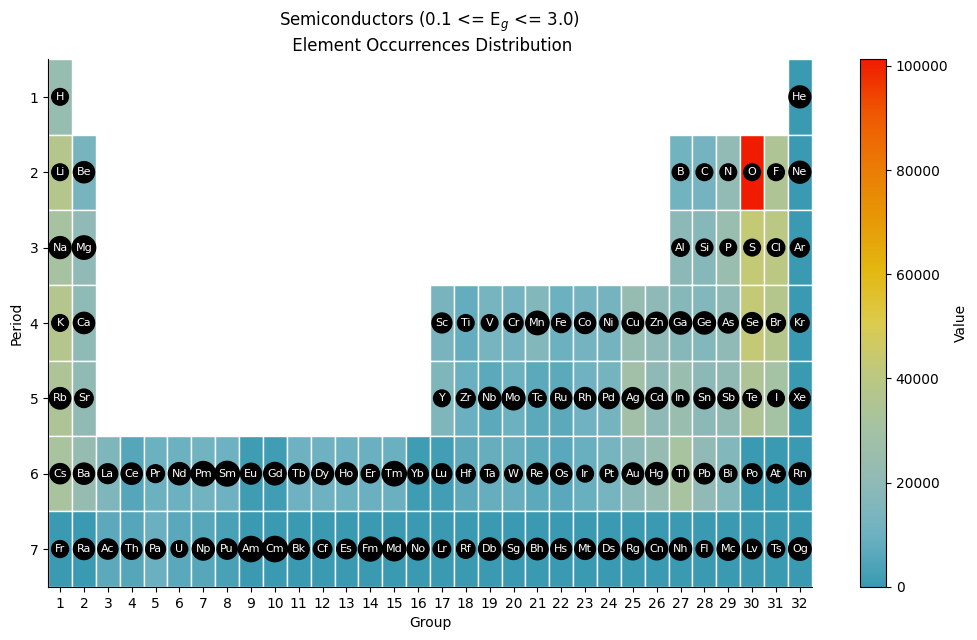

In [32]:
tmp_dict = {
            'symbol': semiconductor_elements.keys(), 
            'value': semiconductor_elements.values(), 
            'extended_group': groups, 
            'period': periods
            }
element_df = pd.DataFrame(tmp_dict, index=symbols)

fig, ax = plot_periodic_table_heatmap(element_df, property_name="value")
ax.set_title("Semiconductors (0.1 <= E$_g$ <= 3.0)\n Element Occurrences Distribution")

fig.set_size_inches(10, 6)

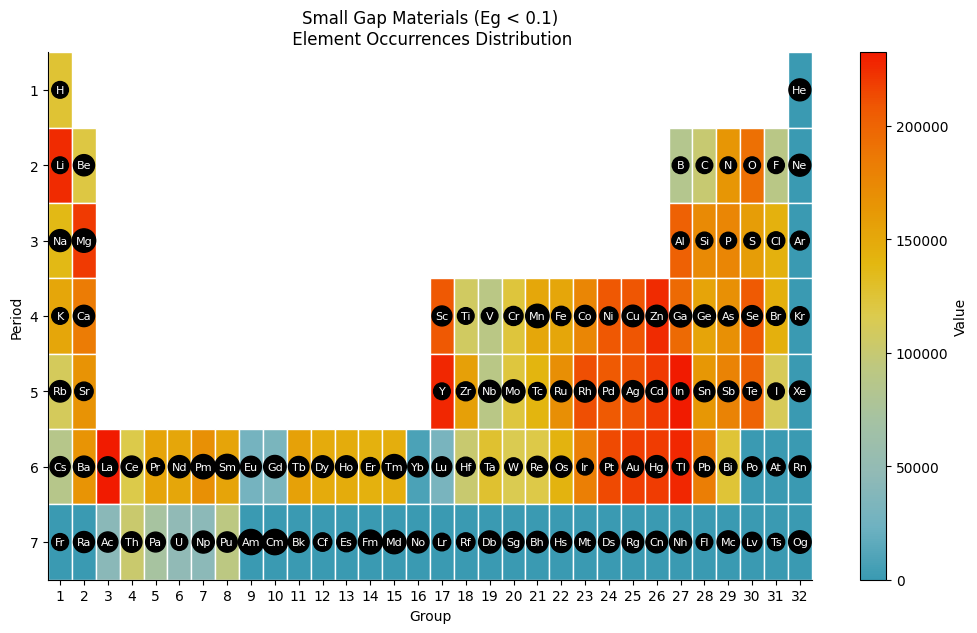

In [33]:
tmp_dict = {
            'symbol': semimetal_elements.keys(), 
            'value': semimetal_elements.values(), 
            'extended_group': groups, 
            'period': periods
            }
element_df = pd.DataFrame(tmp_dict, index=symbols)

fig, ax = plot_periodic_table_heatmap(element_df, property_name="value")
ax.set_title("Small Gap Materials (Eg < 0.1)\n Element Occurrences Distribution")
fig.set_size_inches(10, 6)

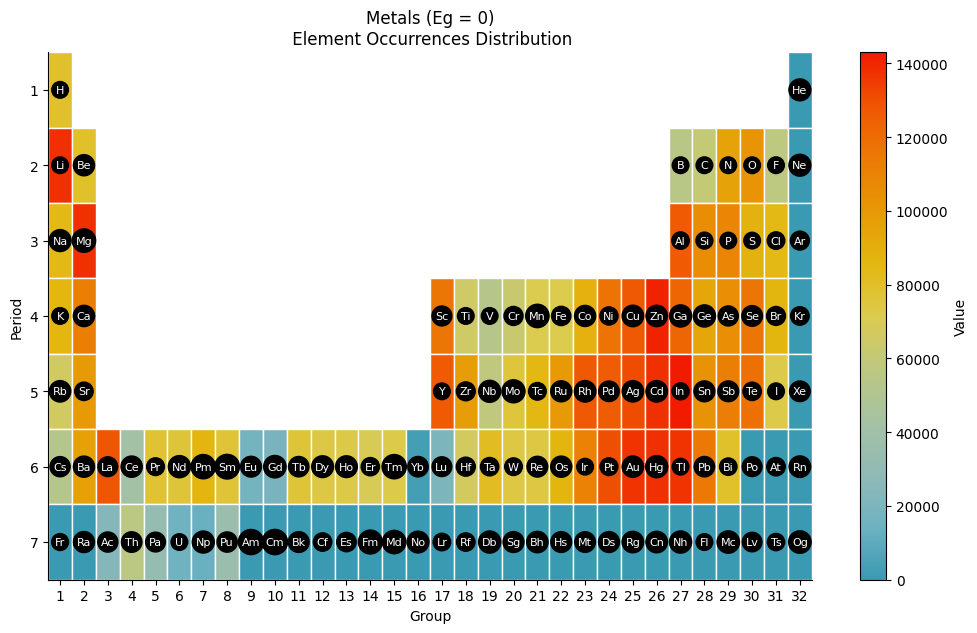

In [34]:
tmp_dict = {
            'symbol': metal_elements.keys(), 
            'value': metal_elements.values(), 
            'extended_group': groups, 
            'period': periods
            }
element_df = pd.DataFrame(tmp_dict, index=symbols)

fig, ax = plot_periodic_table_heatmap(element_df, property_name="value")
ax.set_title("Metals (Eg = 0)\n Element Occurrences Distribution")
fig.set_size_inches(10, 6)

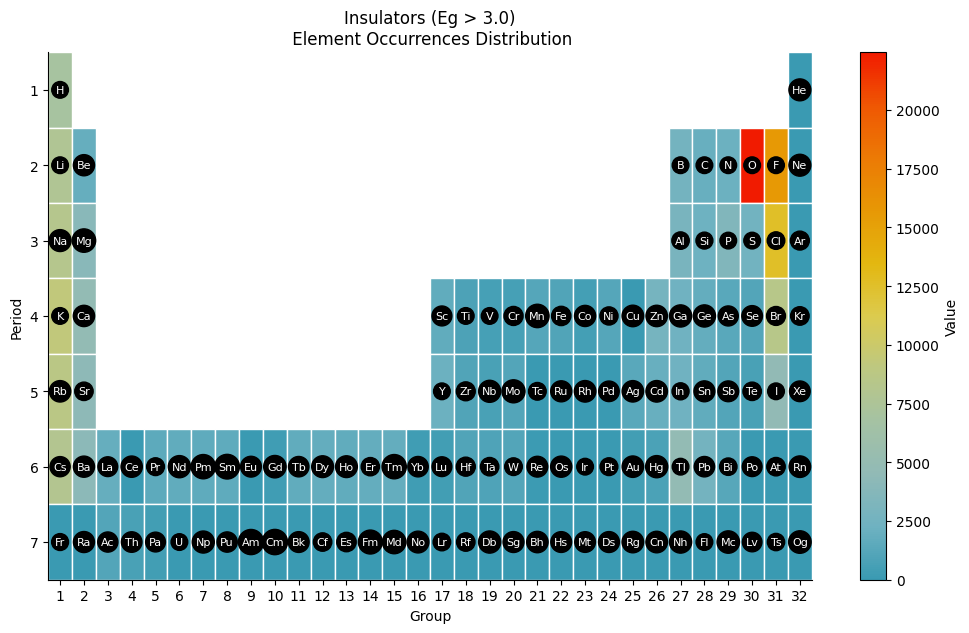

In [35]:
tmp_dict = {
            'symbol': insulator_elements.keys(), 
            'value': insulator_elements.values(), 
            'extended_group': groups, 
            'period': periods
            }
element_df = pd.DataFrame(tmp_dict, index=symbols)

fig, ax = plot_periodic_table_heatmap(element_df, property_name="value")
ax.set_title("Insulators (Eg > 3.0)\n Element Occurrences Distribution")
fig.set_size_inches(10, 6)